In [19]:
%load_ext autoreload
%autoreload 2
import numpy as np
from source.read_HAR_dataset import DatasetHARUML20
from source.read_pamap2 import DatasetPAMAP2
from source.tserie import TSerie
from source.models.manifold.umap_fl import UMAP_FL
from sklearn import metrics
from xgboost import XGBClassifier
from source.utils import MetricsSaver, saveConfusionMatrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from scipy.fft import fft

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
datasetName = 'HAR-UML20' # PAMAP2 or HAR-UML20
FEATURE_SIZE = 32
# CLASS_LABELS = ['Sedentary', 'Light', 'Moderate', 'Vigorous']
UMAP_NEIGHTBORS = 15
N_EPOCHS = 2000
RESULTS_PATH = 'results'

In [21]:


if datasetName == 'PAMAP2':
    dataset = DatasetPAMAP2(mode = 'leave-one-subject', signals=['handAcc16_1', 'handAcc16_2', 'handAcc16_3'])
    
elif datasetName ==  'HAR-UML20':
    dataset = DatasetHARUML20(mode = 'leave-one-subject')
    
CLASS_LABELS = [
    "Sedentary",
    "Light",
    "Moderate",
    "Vigorous",
]

saver = MetricsSaver(datasetName + '_PAI', rows = ['train', 'test'], cols=['F1-score', 'Balanced Accuracy', 'Accuracy'])

In [22]:
predicted_classes = []
real_classes = []
while dataset.loadData():
    # if datasetName == 'PAMAP2':
    #     le = LabelEncoder()
    #     dataset.y_train = le.fit_transform(dataset.Int_train)
    #     dataset.y_test = le.transform(dataset.Int_test)
    
    # Preparing data
    ts_train = TSerie(dataset.X_train, dataset.Int_train)
    ts_test = TSerie(dataset.X_test, dataset.Int_test)
    ts_train.center()
    ts_test.center()
    
    ts_train.features =  np.linalg.norm(ts_train.X[:, :, :3], axis=2)
    ts_test.features = np.linalg.norm(ts_test.X[:, :, :3], axis=2)
    
    for i in range(ts_train.N):
        ts_train.features[i] = np.absolute(fft(ts_train.features[i]))
        
        
    for i in range(ts_test.N):
        ts_test.features[i] = np.absolute(fft(ts_test.features[i]))
    
    # ts_train.folding_features_v2()
    # ts_test.folding_features_v2()
    
    
    # Getting features
    model = UMAP_FL(n_components=FEATURE_SIZE,n_neighbors=UMAP_NEIGHTBORS, n_epochs=N_EPOCHS)
    ts_train.features = model.fit_transform(ts_train.features, y=ts_train.y)
    ts_test.features = model.transform(ts_test.features)
    
    
    # Classifying
    clf = XGBClassifier(tree_method='gpu_hist', predictor='gpu_predictor')
    clf.fit(ts_train.features, ts_train.y)
    train_pr = clf.predict(ts_train.features)
    test_pr = clf.predict(ts_test.features)
    predicted_classes.append(test_pr)
    real_classes.append(ts_test.y)


    # Save metrics
    train_f1 = metrics.f1_score(ts_train.y, train_pr, average='weighted')
    test_f1 = metrics.f1_score(ts_test.y, test_pr, average='weighted')
    train_bacc = metrics.balanced_accuracy_score(ts_train.y, train_pr)
    test_bacc = metrics.balanced_accuracy_score(ts_test.y, test_pr)
    train_acc = metrics.accuracy_score(ts_train.y, train_pr)
    test_acc = metrics.accuracy_score(ts_test.y, test_pr)
    
    saver.addLog('train', 'F1-score', train_f1)
    saver.addLog('test', 'F1-score', test_f1)
    saver.addLog('train', 'Balanced Accuracy', train_bacc)
    saver.addLog('test', 'Balanced Accuracy', test_bacc)
    saver.addLog('train', 'Accuracy', train_acc)
    saver.addLog('test', 'Accuracy', test_acc)
    
predicted_classes = np.concatenate(predicted_classes, axis = 0)
real_classes = np.concatenate(real_classes, axis = 0)

In [23]:
# if datasetName == 'PAMAP2':
#     classes = np.unique(real_classes)
#     CLASS_LABELS = [dataset.activities_map[classL] for classL in le.inverse_transform(classes) ]

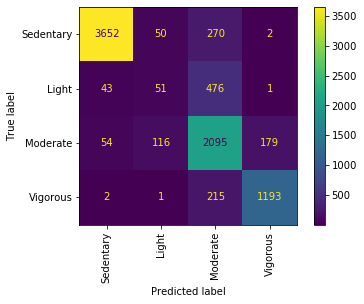

In [24]:

saveConfusionMatrix(real_classes, predicted_classes, datasetName + '_PAI', labels=CLASS_LABELS, xrotation=90)

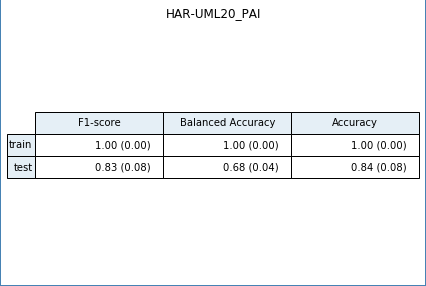

In [25]:
saver.toImage()